In [247]:
import tensorflow as tf
from tensorflow.python.summary.summary_iterator import summary_iterator
from collections import defaultdict
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
from scipy.optimize import curve_fit
#%matplotlib widget
%matplotlib inline

import os
import yaml
from yaml import CLoader as Loader
from glob import glob
import regex as re

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

LOG_PATH = '../logs/'
DL_LOG_PATH = '../dl_logs/logs/'
FINAL_LOG_PATH = '../final_logs/'
MERGED_LOG_PATH = '../dl_logs/merged_logs/'
SPLIT_MERGED_LOG_PATH = '../dl_logs/merged_split_logs/'
TEST_LOG_PATH = '../dl_logs/logs_test_dir/'
TO_MERGE_LOG_PATH = '../dl_logs/to_merge/'




In [248]:
def parse_tb_logs(logs_path, metrics_to_plot, threshold=0.75, verbose=False, delete_dir=False):
    values = defaultdict(list)
    if os.path.isdir(join(logs_path, "metrics_synth")):
        metrics_path = join(logs_path, "metrics_synth")
    elif os.path.isdir(join(logs_path, "metrics")):
        metrics_path = join(logs_path, "metrics")
    else:
        print("ERR: logs not found")
        return [], []
        
    list_folds = os.listdir(metrics_path)
    list_folds = [el for el in list_folds if "DS_Store" not in el]
    if len(list_folds) < 1:
        shutil.rmtree(logs_path)
        print(f"{bcolors.FAIL}No folds found: unsuccessful run{bcolors.ENDC}")
        return defaultdict(list), dict()
                              
    for fold_path in list_folds:
        logs_fold_path = join(metrics_path, fold_path)
        match = re.search("fold_([0-9]+)", fold_path)
        fold_nb = int(match.group(1))
        fold_string=f"fold_{fold_nb}"
        if verbose: print(fold_string, end='  ')
    
        event_acc = EventAccumulator(logs_fold_path)
        event_acc.Reload()
        
        #print(event_acc.Tags())
        for tag in metrics_to_plot:
            try:
                _, step_nums, vals = zip(*event_acc.Scalars(tag))
                if verbose:
                    if tag == 'val_acc':
                        print(f"#logged: {len(vals)}, Max_acc: {max(vals):.3}", end=" ")
                    if tag == 'val_step':
                        print(f"Max_step: {int(max(vals))}", end=" ")
                if len(vals) < 2 or ('acc' in tag and max(vals) < threshold):
                    print(f"{bcolors.FAIL}unsuccessful run{bcolors.ENDC}")
                    return defaultdict(list), dict()
                values[tag].append(list(np.around(vals, 4)))
                values[f'{tag}_step'].append(list(step_nums))
                values['fold_nb'].append(fold_nb)
            except:
                print(f"{bcolors.WARNING}warning: {tag} not in logs{bcolors.ENDC}")
                return defaultdict(list), dict()
                
        if verbose: print()
    print(f'#folds: {len(list_folds)}')
        
    with open(join(logs_fold_path, 'hparams.yaml')) as file:
        hparams_dict = yaml.load(file, Loader=Loader)
    
    fold_ckpts = [y for x in os.walk(logs_path) for y in glob(os.path.join(x[0], '*.ckpt'))]
    hparams_dict.pop('args', None)
        
    return values, hparams_dict

In [249]:
def neg_log(x, a):
    return a * np.log(x)

def neg_exp(x, a, b, c):
    if isinstance(x, list):
        return [-np.exp(-el*a+b)+c for el in x]
    else:
        return -np.exp(-x*a+b)+c

def interpolate_values(metrics_to_plot, values, x_values, tot_num_values=100, curvefit=False):
    interp_values = defaultdict(list)

    for metric_name in metrics_to_plot:
        val_cond = 'val' in metric_name
        max_epochs_real = max([max(el) for el in x_values])
        x = np.linspace(0, max_epochs_real, num=tot_num_values)
        y_vals_interp, y_vals_raw, x_vals_raw = [], [], []
        
        for steps, vals in zip(x_values, values[metric_name]):
            y_vals_interp.append(np.interp(x, steps, vals))
            y_vals_raw.append(vals)
            x_vals_raw.append(steps)
        
        x_values_flat = [item for x_val in x_values for item in x_val]
        metric_values_flat = [item for val in values[metric_name] for item in val]
        
        interp_values[f'{metric_name}_interp_steps'] = list(x)
        interp_values[f'{metric_name}_interp_mean'] = np.mean(y_vals_interp, axis=0)
        var1 = np.var(y_vals_interp, axis=0)
        var2 = np.sum((np.array([el - np.mean(y_vals_interp, axis=0) for el in y_vals_interp]))**2, axis=0) / len(y_vals_interp)
        interp_values[f'{metric_name}_interp_var'] = var2
        
        #y_mean_raw = np.mean(y_vals_raw, axis=0) # does not make sense unless same x for all folds (possible for b5000 b10000)
        #a_opt, _ = curve_fit(neg_log, x_vals_raw, y_mean_raw)
        if 'acc' in metric_name and curvefit:
            a_opt, _ = curve_fit(neg_exp, x, interp_values[f'{metric_name}_interp_mean'], [0.00001, 0.1, 0.1]) # shouldnt be used here bc requires many more points (continuous)
            #print('a_opt', a_opt, max(neg_exp(list(x), *a_opt)))
            interp_values[f'{metric_name}_curvefit_var'] = np.min([neg_exp(list(x), *a_opt), np.ones(len(list(x)))], axis=0)
    
    return interp_values, (x_values_flat, metric_values_flat)

In [250]:
def plot_metrics(metrics_to_plot, interp_values_df, ax, label, epochs_values=None, color=None, 
                 values_flat=None, plot_points=False, plot_curvefit=False):
    
    for i, metric_name in enumerate(metrics_to_plot):
        if epochs_values == None:
            epochs = interp_values_df[f'{metric_name}_interp_steps']
        else:
            epochs = np.linspace(0, max([max(el) for el in epochs_values]), interp_values_df.shape[0])
        
        mean_val = interp_values_df[f'{metric_name}_interp_mean']
        var_val = interp_values_df[f'{metric_name}_interp_var']
        
        # if we have too many values at convergence
        cutoff = [i for i, n in enumerate(mean_val) if n > 0.99]
        if len(cutoff) < 200:
            cutoff = -1
        else:
            cutoff=cutoff[199]
            
        epochs, mean_val,var_val = epochs[:cutoff], mean_val[:cutoff],var_val[:cutoff]    

        p=ax[i].plot(epochs, mean_val, label=label, color=color) #, yerr=var_val)
        ax[i].fill_between(epochs, mean_val-var_val, mean_val+var_val, alpha=0.2, facecolor=p[-1].get_color())
        ax[i].set_title(metric_name)
        ax[i].set_xlabel("steps")
        if 'acc' in metric_name:
            ax[i].plot(epochs, np.ones(len(epochs)) * 0.95, '--k', linewidth=1, alpha=0.6)
            if plot_points and values_flat:
                ax[i].scatter(values_flat[0], values_flat[1], color=color, marker='o', s=3, alpha=0.25)
            if plot_curvefit:
                ax[i].plot(interp_values_df[f'{metric_name}_interp_steps'], interp_values_df[f'{metric_name}_curvefit_var'], '--', color=p[-1].get_color(), lw=1, alpha=0.7)
            
        if metric_name == 'val_acc':
            val_acc_curve = p[0].get_data()
        
    return val_acc_curve

def create_run_dict(hparams_dict, metric_values, ckpt_name):
    hparams_dict['name'] = ckpt_name
    hparams_dict['eval_steps'] = []
    hparams_dict['best_score'] = max([max(el) for el in metric_values['val_acc']])
    return hparams_dict
        
        
def parse_regex(ckpt_name):
    match=re.search(re.compile("(?:(mnist)|_d([0-9]+))"), ckpt_name)
    depth=match.group(1)
    match=re.search(re.compile("_b([0-9]+)"), ckpt_name)
    b_len=int(match.group(1))
    match=re.search(re.compile("_rep([0-9]+)"), ckpt_name)
    repetition_nb=int(match.group(1))

    patt = "(?:merged_)*([0-9]+)_([0-9]+)_[0-9]+_[a-z]+_((?:um|rand|split)_b[0-9]+_*(d[0-9]+)*_*(s[0-9]*)*_+h[0-9]+_lr[0-9.]+_rep[0-9]+)"
    matched = re.match(patt, ckpt_name)
    hash1 = matched.group(3) # create hash
    job_id = int(matched.group(1))
    date_launched = int(matched.group(2))

    return depth, b_len, repetition_nb, hash1, job_id, date_launched

def plot_agg_metrics(metrics_to_plot, logs_paths, checkpoints, 
                     name: str=None, tot_num_values=200, 
                     plot_legend=0, val_epochs_logged=False, threshold=0.75, 
                     color_patt=None, verbose=False, delete_dir=False):
    highscore_table = []
    f,a = plt.subplots(1, len(metrics_to_plot)-1)
    f.set_size_inches(15,5)
    f.tight_layout()
    plt.ylim(0,1.1)
    tot_len_ckpt = len(logs_paths)
    all_metric_values_dict = dict()
    all_hparams_dict = dict()
    is_labeled = []
    max_rep = defaultdict(lambda:1)
    val_accs_dict = dict()
        
    for i, (logs_path, ckpt_name) in enumerate(zip(logs_paths, checkpoints)):
        print(ckpt_name)

        depth, b_len, repetition_nb, hash1, job_id, date_launched = parse_regex(ckpt_name)
        hash1_no_rep = hash1[:hash1.rfind('_')]
        max_rep[hash1_no_rep] = max(max_rep[hash1_no_rep], repetition_nb)

        metric_values, hparams_dict = parse_tb_logs(logs_path, metrics_to_plot, threshold=threshold, 
                                                    verbose=verbose, delete_dir=delete_dir)  
        hparams_dict['name'] = ckpt_name
        hparams_dict['job_id'] = job_id
        hparams_dict['date'] = date_launched
        
        # USED TO MERGE TWO PARTS OF THE SAME RUN
        #if hash1 in all_metric_values_dict.keys() and np.isclose(int(all_hparams_dict[hash1]['job_id']), job_id, atol=4):
        #    #merge...
        #    for key1 in all_metric_values_dict[hash1].keys():
        #        all_metric_values_dict[hash1][key1].append(metric_values[key1])
        #   list_steps = all_metric_values_dict[hash1]['val_step']
            
        #    for key1, metric_list in all_metric_values_dict[hash1].items():   
        #        all_metric_values_dict[hash1][key1] = [x for _, x in sorted(zip(list_steps, metric_list))]
        #else:
        all_metric_values_dict[hash1] = metric_values
        all_hparams_dict[hash1] = hparams_dict
            
        #highscore_table.append(create_run_dict(hparams_dict, metric_values, ckpt_name))   
    successfull_run_keys = [hash1 for hash1 in all_metric_values_dict.keys() if len(all_metric_values_dict[hash1]['val_acc']) > 0]
    
    for i, hash1 in enumerate(sorted(successfull_run_keys)):
        metric_values, hparams_dict = all_metric_values_dict[hash1], all_hparams_dict[hash1]
        
        print(hash1)
        interp_values, values_flat = interpolate_values(metrics_to_plot=['val_loss', 'val_acc'], 
                                                   values=metric_values, x_values=metric_values['val_step'],
                                                   tot_num_values=tot_num_values)
        interp_values_df = pd.DataFrame(interp_values)
        hash1_no_rep = hash1[:hash1.rfind('_')]
        #all_metric_values_dict[hash1]['val_acc_interp'] = interp_values_df['val_acc_interp_mean']
        
        hash_is_labeled = True
        if hash1_no_rep not in is_labeled:
            hash_is_labeled = False
            is_labeled.append(hash1_no_rep)
            
        if color_patt == None:
            color_nb = is_labeled.index(hash1_no_rep)
            cmap = plt.get_cmap(cm_names[color_nb])
            #cmap = plt.get_cmap(cm_names[0])
            #color = cmap(np.log10(hparams_dict['b_len']+1)/np.log10(1e4)) #cmap(lightness)
            color=cmap(0.5)
        elif color_patt == 'discrete':
            color = None
            
        label = None
        if plot_legend == 1 and not hash_is_labeled:
            label = str(hparams_dict['date'])+str(hash1_no_rep)
           
        line_points_vals = plot_metrics(metrics_to_plot=['val_loss', 'val_acc'], interp_values_df=interp_values_df, 
                     ax=a, label=label, epochs_values=None, color=color, values_flat=values_flat)
        val_accs_dict[hash1] = line_points_vals
        
    if plot_legend > 0:
        for ax in a:
            ax.legend()        
        
    f.subplots_adjust(hspace=0.2)
    if name:
        f.savefig(f'../plots/{name}.jpg', dpi=300)
        
    return highscore_table, val_accs_dict


def plot_runs_w_regex(re_patt_to_search, threshold, log_path=LOG_PATH, verbose=False, delete_dir=False):
    plot_name=f"plot_>{threshold}_{re_patt_to_search}"
    all_ckpt_dirs = os.listdir(log_path)
    all_ckpt_dirs = [el for el in all_ckpt_dirs if "DS_Store" not in el]
    all_ckpt_dirs = [el for el in all_ckpt_dirs if re.search(re_patt_to_search, el)]
    
    all_ckpt_dirs = sorted(all_ckpt_dirs, key=lambda d: int(re.search('b([0-9]+)', d).group(1)), reverse=False)
    all_ckpt_dirs = sorted(all_ckpt_dirs, key=lambda d: float(re.search('lr([0-9.]+)', d).group(1)), reverse=True)

    logs_paths = [join(log_path, ckpt) for ckpt in all_ckpt_dirs]
    print(f"{bcolors.OKGREEN}#logged paths : {len(logs_paths)} {bcolors.ENDC}")
    highscore_table, val_accs_dict = plot_agg_metrics(metrics_to_plot, logs_paths, all_ckpt_dirs,
                                                       name=plot_name, tot_num_values=10000, plot_legend=1,
                                                       threshold=threshold, color_patt=None, verbose=verbose, 
                                                       delete_dir=delete_dir)
    plt.show()
    return val_accs_dict




In [251]:
def compute_integral_values(val_accs_dict):
    hash_b1 = None
    b1_curve = None
    b0_max_step = 0
    for hash1 in val_accs_dict.keys():  ## on soustrait tt a B1
        if '_b1_' in hash1:
            print(hash1)
            hash_b1 = hash1
            b1_curve = val_accs_dict[hash1]
            #print('b1 selected: ', hash_b1)
            del val_accs_dict[hash1]
            break
            
    if b1_curve == None:
        print(f"{bcolors.FAIL}ERROR: No b1 run found as baseline{bcolors.ENDC}")
        return {}, '', 0
    
    integral_vals = dict()
    for hash1, curve1 in val_accs_dict.items(): # curve1 is a tuple with (x_vals, y_vals)
        if '_b0_' in hash1:
            b0_max_idx = np.argmax(curve1[1])
            b0_max_step = int(curve1[0][b0_max_idx])
            
        bx_y_interp, b1_y_interp, dx, max_val = align_curves(curve1, b1_curve)
        integral_vals[hash1] = riemann_sum(bx_y_interp, b1_y_interp, dx, max_val)
    
    return (integral_vals, hash_b1, b0_max_step)

def align_curves(points1, points2):
    max_val = int(min(max(points1[0]), max(points2[0])))
    
    idx1 = np.argwhere(points1[0] < max_val).flatten()
    idx2 = np.argwhere(points2[0] < max_val).flatten()
    new_points1 = [el[idx1] for el in points1]
    new_points2 = [el[idx2] for el in points2]
    x_interp_points = np.linspace(0, max_val, 100)
    points1_y_interp = np.interp(x_interp_points, new_points1[0], new_points1[1])
    points2_y_interp = np.interp(x_interp_points, new_points2[0], new_points2[1])
    dx = x_interp_points[1:] - x_interp_points[:-1]
    
    return points1_y_interp, points2_y_interp, dx, max_val

def riemann_sum(points1, points2, dx, max_val):
    y = points2 - points1
    res = np.sum((y[:-1] + y[1:]) * 0.5 * dx) / max_val
    return res
    

In [252]:
#metrics_to_plot = ['val_loss', 'val_acc', 'val_ap', 'val_auroc', 
#                   'train_loss_epoch', 'train_acc', 'train_ap']

cm_names = ['Blues', 'Greens', 'Oranges', 'Reds', 'Greys', 'Purples', 'PuRd', 'ocean', 'cool', 'autumn','winter']
metrics_to_plot = ['val_loss', 'val_acc', 'val_step']


# Filtered graphs

## Synthetic Dataset

### Small verification run

#logged paths : 70 
2629318_2206_2224_synth_split_b0_d5_s400_h60_lr1.0_rep16
fold_16  #logged: 450, Max_acc: 1.0 Max_step: 44900 
#folds: 1
2629313_2206_2224_synth_split_b0_d5_s400_h60_lr1.0_rep11
fold_11  #logged: 444, Max_acc: 1.0 Max_step: 44300 
#folds: 1
2629316_2206_2224_synth_split_b0_d5_s400_h60_lr1.0_rep14
fold_14  #logged: 407, Max_acc: 1.0 Max_step: 40600 
#folds: 1
2629314_2206_2224_synth_split_b0_d5_s400_h60_lr1.0_rep12
fold_12  #logged: 410, Max_acc: 1.0 Max_step: 40900 
#folds: 1
2629321_2206_2224_synth_split_b0_d5_s400_h60_lr1.0_rep19
fold_19  #logged: 487, Max_acc: 1.0 Max_step: 48600 
#folds: 1
2629319_2206_2224_synth_split_b0_d5_s400_h60_lr1.0_rep17
fold_17  #logged: 441, Max_acc: 1.0 Max_step: 44000 
#folds: 1
2629312_2206_2224_synth_split_b0_d5_s400_h60_lr1.0_rep10
fold_10  #logged: 386, Max_acc: 1.0 Max_step: 38500 
#folds: 1
2629320_2206_2224_synth_split_b0_d5_s400_h60_lr1.0_rep18
fold_18  #logged: 538, Max_acc: 1.0 Max_step: 53700 
#folds: 1
2629317_2206_2224_sy

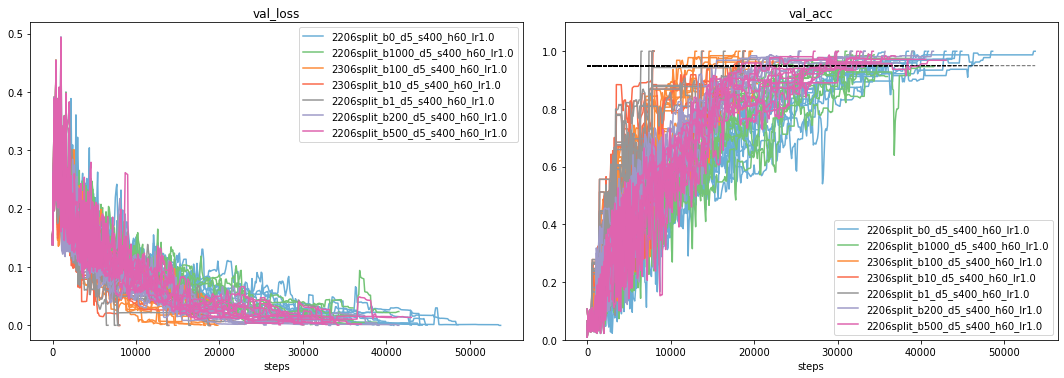

split_b1_d5_s400_h60_lr1.0_rep10
integral_values {'split_b0_d5_s400_h60_lr1.0_rep10': 0.276913943208645, 'split_b0_d5_s400_h60_lr1.0_rep11': 0.19039313159399052, 'split_b0_d5_s400_h60_lr1.0_rep12': 0.28737534287176947, 'split_b0_d5_s400_h60_lr1.0_rep13': 0.2575594649586921, 'split_b0_d5_s400_h60_lr1.0_rep14': 0.28866239211596284, 'split_b0_d5_s400_h60_lr1.0_rep15': 0.2705223601045628, 'split_b0_d5_s400_h60_lr1.0_rep16': 0.2888943432666549, 'split_b0_d5_s400_h60_lr1.0_rep17': 0.27574478786220125, 'split_b0_d5_s400_h60_lr1.0_rep18': 0.25745490748541233, 'split_b0_d5_s400_h60_lr1.0_rep19': 0.32679000562220006, 'split_b1000_d5_s400_h60_lr1.0_rep10': 0.257822549501648, 'split_b1000_d5_s400_h60_lr1.0_rep11': 0.1847598743920616, 'split_b1000_d5_s400_h60_lr1.0_rep12': 0.264544386138546, 'split_b1000_d5_s400_h60_lr1.0_rep13': 0.22808110263415407, 'split_b1000_d5_s400_h60_lr1.0_rep14': 0.30137676308002115, 'split_b1000_d5_s400_h60_lr1.0_rep15': 0.225323918057645, 'split_b1000_d5_s400_h60_lr1.0_r

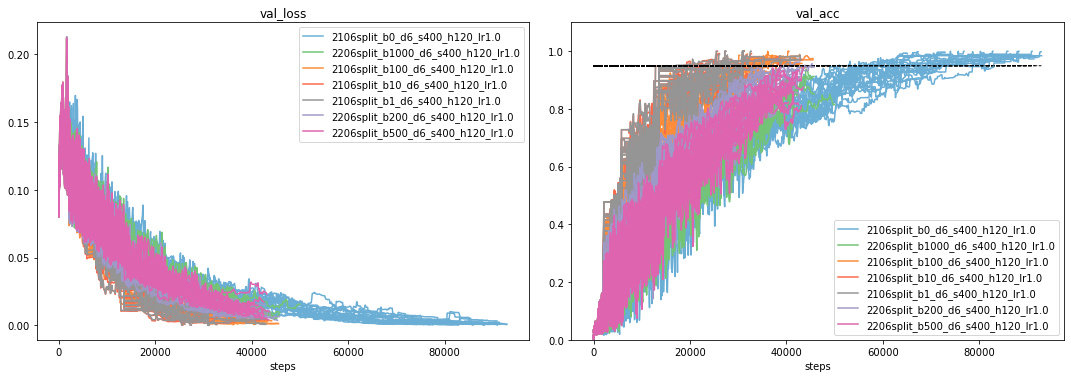

split_b1_d6_s400_h120_lr1.0_rep0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


integral_values {'split_b0_d6_s400_h120_lr1.0_rep0': 0.36044422425873063, 'split_b0_d6_s400_h120_lr1.0_rep1': 0.36892380772756295, 'split_b0_d6_s400_h120_lr1.0_rep10': 0.36085424158172574, 'split_b0_d6_s400_h120_lr1.0_rep11': 0.33701625267401697, 'split_b0_d6_s400_h120_lr1.0_rep12': 0.34221798575355583, 'split_b0_d6_s400_h120_lr1.0_rep13': 0.356799749666666, 'split_b0_d6_s400_h120_lr1.0_rep14': 0.32779816623922153, 'split_b0_d6_s400_h120_lr1.0_rep15': 0.3212973915678053, 'split_b0_d6_s400_h120_lr1.0_rep16': 0.34644600508747353, 'split_b0_d6_s400_h120_lr1.0_rep17': 0.3435340183298402, 'split_b0_d6_s400_h120_lr1.0_rep18': 0.32218897898876286, 'split_b0_d6_s400_h120_lr1.0_rep19': 0.3602199622809378, 'split_b0_d6_s400_h120_lr1.0_rep2': 0.317632772697524, 'split_b0_d6_s400_h120_lr1.0_rep3': 0.33883554463184695, 'split_b0_d6_s400_h120_lr1.0_rep4': 0.3702122793974285, 'split_b0_d6_s400_h120_lr1.0_rep5': 0.3693580462065975, 'split_b0_d6_s400_h120_lr1.0_rep6': 0.3578557317471149, 'split_b0_d6_s

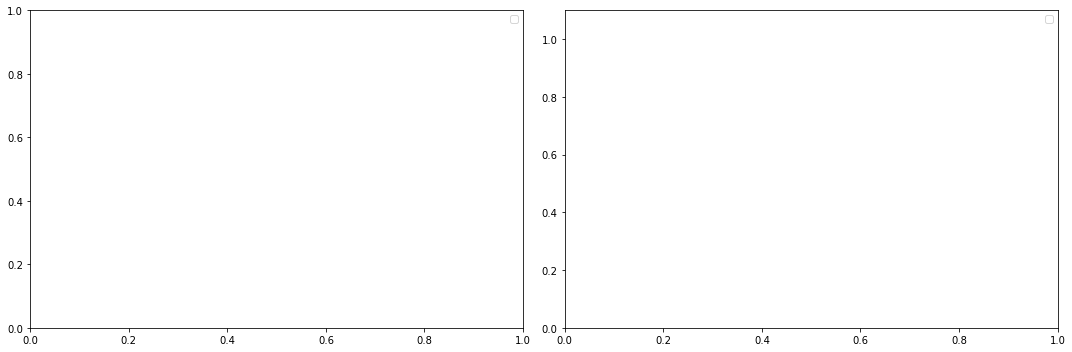

ERROR: No b1 run found as baseline
integral_values {}


In [536]:
integral_values_dict_um, integral_values_dict_split = dict(), dict()
patts_to_search = ['synth_um_b[0-9]*_d5_+h60_lr2', 'synth_um_b[0-9]*_d6_+h120_lr2', 'synth_um_b[0-9]*_d7_+h250_lr2', 'synth_um_b[0-9]*_d8_+h500_lr5'] # 'synth_um_b[01]*_d9_h1000_lr5']
patts_to_search = ['synth_split_b[0-9]*_d5_*(s[0-9]*)*_h[0-9]+_lr', 'synth_split_b[0-9]*_d6_s400_h[0-9]+_lr', 'synth_split_b[0-9]*_d6_s700_h[0-9]+_lr']
#patts_to_search = ['synth_split_b[0-9]*_d6_*(s[0-9]*)*_h[0-9]+_lr']
# MERGED_LOG_PATH DL_LOG_PATH SPLIT_MERGED_LOG_PATH

for patt in patts_to_search: 
    val_accs_dict = plot_runs_w_regex(patt, 0.1, DL_LOG_PATH, verbose=True, delete_dir=False)
    integral_values, name, b0_max_idx = compute_integral_values(val_accs_dict)
    print('integral_values', integral_values)
    res_dict[name] = (integral_values, b0_max_idx)

### Run

#logged paths : 9 
merged_2550576_0706_0057_synth_um_b0_d5_h60_lr2.0_rep0
#folds: 50
merged_2604188_1706_1722_synth_um_b1_d5_h60_lr2.0_rep0
#folds: 30
merged_2604218_1706_1800_synth_um_b10_d5_h60_lr2.0_rep0
#folds: 30
merged_2604157_1706_1602_synth_um_b100_d5_h60_lr2.0_rep0
#folds: 30
merged_2602139_1606_2143_synth_um_b200_d5_h60_lr2.0_rep0
#folds: 30
merged_2602445_1706_1112_synth_um_b500_d5_h60_lr2.0_rep0
#folds: 30
merged_2602475_1706_1248_synth_um_b1000_d5_h60_lr2.0_rep0
#folds: 30
merged_2602505_1706_1348_synth_um_b5000_d5_h60_lr2.0_rep0
#folds: 30
merged_2602535_1706_1438_synth_um_b10000_d5_h60_lr2.0_rep0
#folds: 30
um_b0_d5_h60_lr2.0_rep0
um_b10000_d5_h60_lr2.0_rep0
um_b1000_d5_h60_lr2.0_rep0
um_b100_d5_h60_lr2.0_rep0
um_b10_d5_h60_lr2.0_rep0
um_b1_d5_h60_lr2.0_rep0
um_b200_d5_h60_lr2.0_rep0
um_b5000_d5_h60_lr2.0_rep0
um_b500_d5_h60_lr2.0_rep0


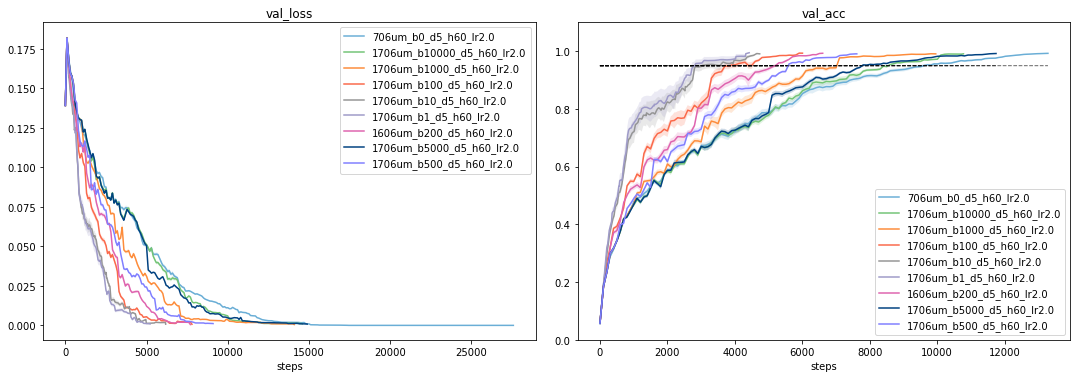

um_b1_d5_h60_lr2.0_rep0
integral_values {'um_b0_d5_h60_lr2.0_rep0': 0.24269792593334724, 'um_b10000_d5_h60_lr2.0_rep0': 0.24563076717944068, 'um_b1000_d5_h60_lr2.0_rep0': 0.20881974657103283, 'um_b100_d5_h60_lr2.0_rep0': 0.09783539014010356, 'um_b10_d5_h60_lr2.0_rep0': 0.018260179071183404, 'um_b200_d5_h60_lr2.0_rep0': 0.14161009521545959, 'um_b5000_d5_h60_lr2.0_rep0': 0.24390070050618495, 'um_b500_d5_h60_lr2.0_rep0': 0.1804630152799861}
#logged paths : 9 
merged_2602173_1606_2209_synth_um_b0_d6_h120_lr2.0_rep0
#folds: 30
merged_2602203_1706_0015_synth_um_b1_d6_h120_lr2.0_rep0
#folds: 30
merged_2602233_1706_0146_synth_um_b10_d6_h120_lr2.0_rep0
#folds: 30
merged_2602263_1706_0242_synth_um_b100_d6_h120_lr2.0_rep0
#folds: 30
merged_2602293_1706_0332_synth_um_b200_d6_h120_lr2.0_rep0
#folds: 30
merged_2602323_1706_0510_synth_um_b500_d6_h120_lr2.0_rep0
#folds: 30
merged_2602353_1706_0626_synth_um_b1000_d6_h120_lr2.0_rep0
#folds: 30
merged_2602383_1706_0800_synth_um_b5000_d6_h120_lr2.0_rep0
#

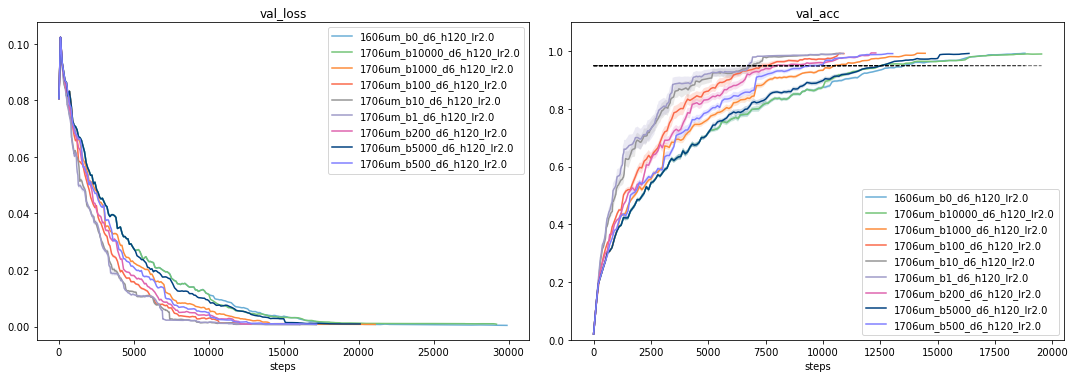

um_b1_d6_h120_lr2.0_rep0
integral_values {'um_b0_d6_h120_lr2.0_rep0': 0.16976203944144413, 'um_b10000_d6_h120_lr2.0_rep0': 0.16834389493291763, 'um_b1000_d6_h120_lr2.0_rep0': 0.12160988529992049, 'um_b100_d6_h120_lr2.0_rep0': 0.05366496568583253, 'um_b10_d6_h120_lr2.0_rep0': 0.01121471212114694, 'um_b200_d6_h120_lr2.0_rep0': 0.07698883741838668, 'um_b5000_d6_h120_lr2.0_rep0': 0.15918147219452156, 'um_b500_d6_h120_lr2.0_rep0': 0.10537984087215317}
#logged paths : 9 
merged_2555412_0706_1459_synth_um_b0_d7_h250_lr2.0_rep0
#folds: 50
merged_2607018_1806_2323_synth_um_b1_d7_h250_lr2.0_rep0
#folds: 30
merged_2607048_1806_2323_synth_um_b10_d7_h250_lr2.0_rep0
#folds: 28
merged_2607078_1806_2323_synth_um_b100_d7_h250_lr2.0_rep0
#folds: 30
merged_2607108_1906_0204_synth_um_b200_d7_h250_lr2.0_rep0
#folds: 30
merged_2605001_1706_2341_synth_um_b500_d7_h250_lr2.0_rep0
#folds: 29
merged_2605031_1706_2341_synth_um_b1000_d7_h250_lr2.0_rep0
#folds: 29
merged_2605061_1806_0343_synth_um_b5000_d7_h250_lr2

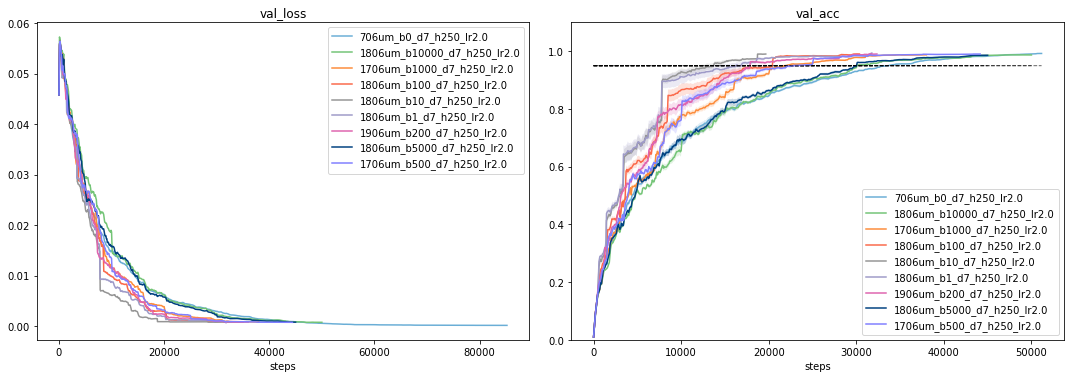

um_b1_d7_h250_lr2.0_rep0
integral_values {'um_b0_d7_h250_lr2.0_rep0': 0.12792765988965143, 'um_b10000_d7_h250_lr2.0_rep0': 0.13455490611295237, 'um_b1000_d7_h250_lr2.0_rep0': 0.07359244661032421, 'um_b100_d7_h250_lr2.0_rep0': 0.0303128099578728, 'um_b10_d7_h250_lr2.0_rep0': -0.0058557935178234636, 'um_b200_d7_h250_lr2.0_rep0': 0.0393047713523982, 'um_b5000_d7_h250_lr2.0_rep0': 0.12074326688979038, 'um_b500_d7_h250_lr2.0_rep0': 0.06074920114041475}
#logged paths : 9 
merged_2556663_0706_1827_synth_um_b0_d8_h500_lr5.0_rep0
#folds: 10
merged_2607152_1906_0634_synth_um_b1_d8_h500_lr5.0_rep0
#folds: 30
merged_2607212_1906_1122_synth_um_b10_d8_h500_lr5.0_rep0
#folds: 30
merged_2607272_1906_1607_synth_um_b100_d8_h500_lr5.0_rep0
#folds: 30
merged_2607332_1906_2056_synth_um_b200_d8_h500_lr5.0_rep0
#folds: 30
merged_2607140_1906_0508_synth_um_b500_d8_h500_lr5.0_rep0
#folds: 29
merged_2607189_1906_0946_synth_um_b1000_d8_h500_lr5.0_rep0
#folds: 30
merged_2607249_1906_1414_synth_um_b5000_d8_h500_lr

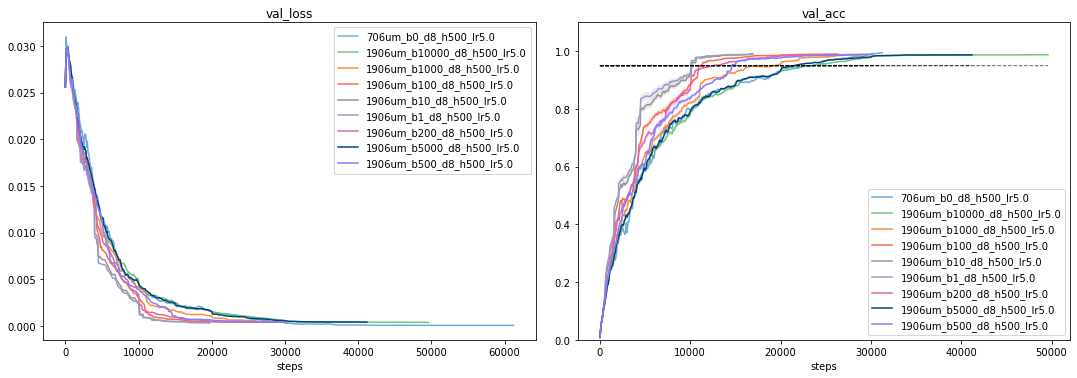

um_b1_d8_h500_lr5.0_rep0
integral_values {'um_b0_d8_h500_lr5.0_rep0': 0.14224488090585646, 'um_b10000_d8_h500_lr5.0_rep0': 0.14529107618614173, 'um_b1000_d8_h500_lr5.0_rep0': 0.10743695846823739, 'um_b100_d8_h500_lr5.0_rep0': 0.050710628294945506, 'um_b10_d8_h500_lr5.0_rep0': 0.01268132914307724, 'um_b200_d8_h500_lr5.0_rep0': 0.06394676799022493, 'um_b5000_d8_h500_lr5.0_rep0': 0.13843782668466414, 'um_b500_d8_h500_lr5.0_rep0': 0.09392455813618263}
#logged paths : 7 
merged_2604990_1706_2341_synth_split_b0_d5_s400_h60_lr1.0_rep0
#folds: 10
merged_2604992_1706_2341_synth_split_b1_d5_s400_h60_lr1.0_rep0
#folds: 7
merged_2604994_1706_2341_synth_split_b10_d5_s400_h60_lr1.0_rep0
#folds: 9
merged_2607381_2006_0104_synth_split_b100_d5_s400_h60_lr1.0_rep0
#folds: 10
merged_2607383_2006_0113_synth_split_b200_d5_s400_h60_lr1.0_rep0
#folds: 6
merged_2604996_1706_2341_synth_split_b400_d5_s400_h60_lr1.0_rep0
#folds: 3
merged_2604998_1706_2341_synth_split_b1000_d5_s400_h60_lr1.0_rep0
#folds: 2
split_

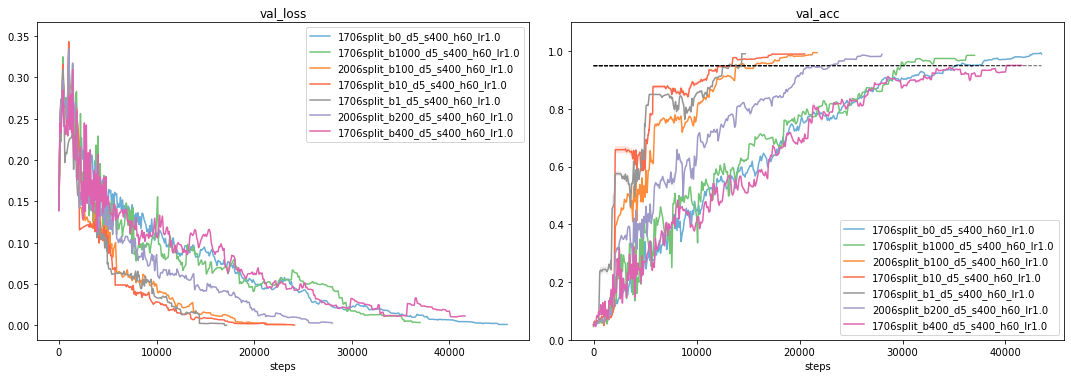

split_b1_d5_s400_h60_lr1.0_rep0
integral_values {'split_b0_d5_s400_h60_lr1.0_rep0': 0.37642093780930524, 'split_b1000_d5_s400_h60_lr1.0_rep0': 0.3387329343222142, 'split_b100_d5_s400_h60_lr1.0_rep0': 0.08281969487013309, 'split_b10_d5_s400_h60_lr1.0_rep0': -0.00785102342901076, 'split_b200_d5_s400_h60_lr1.0_rep0': 0.21436755324272652, 'split_b400_d5_s400_h60_lr1.0_rep0': 0.37258606196566224}
#logged paths : 8 
merged_2604143_1706_1548_synth_split_b0_d6_s700_h120_lr1.0_rep0
unsuccessful run
merged_2623156_2106_0242_synth_split_b0_d6_s400_h120_lr1.0_rep0
#folds: 10
merged_2623166_2106_0242_synth_split_b1_d6_s400_h120_lr1.0_rep0
#folds: 10
merged_2604145_1706_1551_synth_split_b1_d6_s700_h120_lr1.0_rep0
unsuccessful run
merged_2623176_2106_0242_synth_split_b10_d6_s400_h120_lr1.0_rep0
#folds: 10
merged_2623186_2106_0242_synth_split_b100_d6_s400_h120_lr1.0_rep0
unsuccessful run
merged_2623196_2106_0242_synth_split_b200_d6_s400_h120_lr1.0_rep0
unsuccessful run
merged_2604147_1706_1602_synth_s

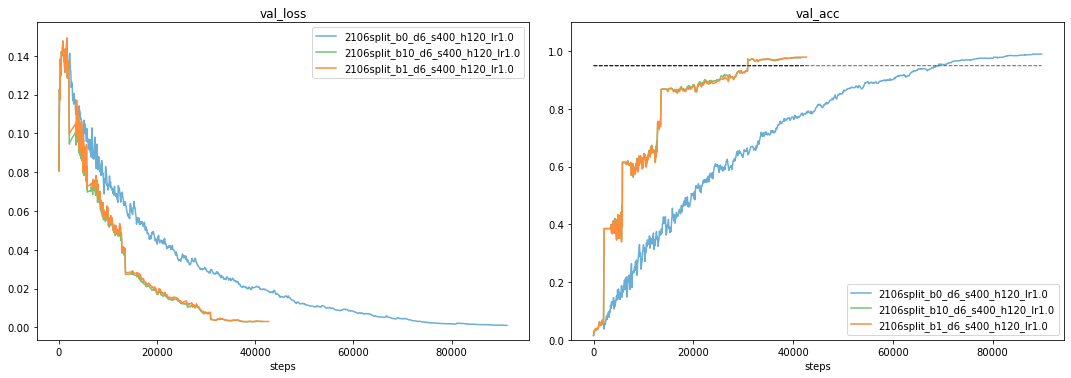

split_b1_d6_s400_h120_lr1.0_rep0
integral_values {'split_b0_d6_s400_h120_lr1.0_rep0': 0.29892658300328684, 'split_b10_d6_s400_h120_lr1.0_rep0': -0.001972030423325025}


In [508]:
mode_list = ['um', 'split']

integral_values_dict_um, integral_values_dict_split = dict(), dict()
patts_to_search_um = ['synth_um_b[0-9]*_d5_+h60_lr2', 'synth_um_b[0-9]*_d6_+h120_lr2', 'synth_um_b[0-9]*_d7_+h250_lr2', 'synth_um_b[0-9]*_d8_+h500_lr5'] # 'synth_um_b[01]*_d9_h1000_lr5']
patts_to_search_split = ['synth_split_b[0-9]*_d5_*(s[0-9]*)*_h[0-9]+_lr', 'synth_split_b[0-9]*_d6_*(s[0-9]*)*_h[0-9]+_lr']

for res_dict, patt_list, log_path in zip([integral_values_dict_um, integral_values_dict_split],
                                         [patts_to_search_um, patts_to_search_split], 
                                         [MERGED_LOG_PATH, SPLIT_MERGED_LOG_PATH]):
    for patt in patt_list: 
        val_accs_dict = plot_runs_w_regex(patt, 0.9, log_path, verbose=False, delete_dir=False)
        integral_values, name, b0_max_idx = compute_integral_values(val_accs_dict)
        print('integral_values', integral_values)
        res_dict[name] = (integral_values, b0_max_idx)

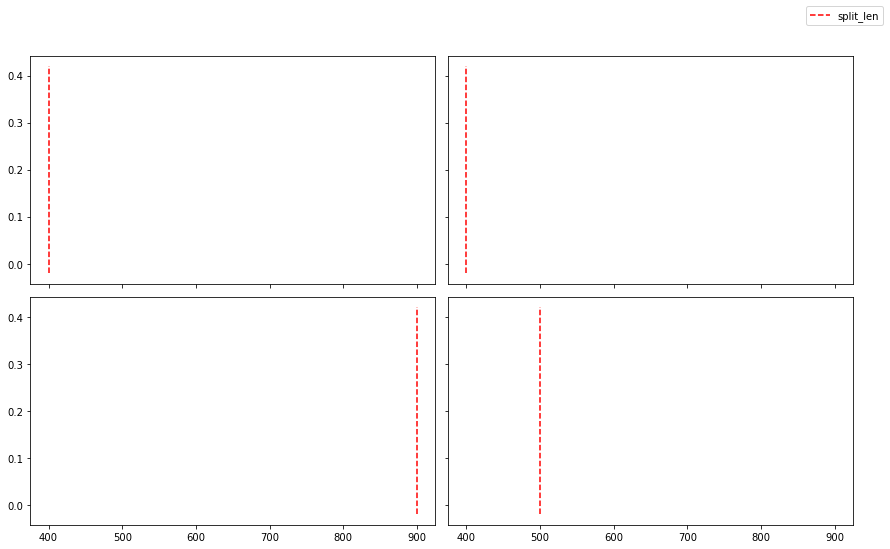

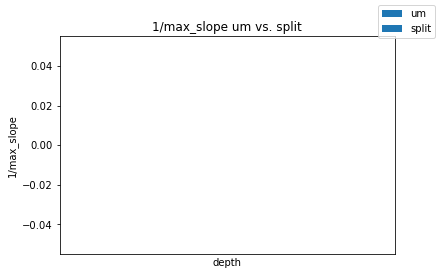

In [507]:
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.signal import argrelextrema

def sigmoid_el(x, a=1, b=0, c=0):
    return 1 / (1 + np.exp(-x*a+b)) + c

def d_sigmoid_el(x, a=1, b=0, c=0):
        return sigmoid_el(x, a, b, c) * (1 - sigmoid_el(x, a, b))

def d_sigmoid(x, a=1, b=0, c=0):
    if isinstance(x, list):
        return [d_sigmoid_el(el,a,b, c) for el in x]
    else:
        return d_sigmoid_el(x,a,b,c )

def sigmoid(x, a=1, b=0, c=0):
    if isinstance(x, list):
        return [sigmoid_el(el, a, b, c) for el in x]
    else:
        return sigmoid_el(x, a, b, c)
    
max_slope_um, max_slope_split = dict(), dict()

f, ax = plt.subplots(2, 2, sharex=True, sharey=True)
f.set_size_inches(12,7)
y_lim_vals = (-0.02, 0.42)
for j, (mode, res_dict) in enumerate(zip(mode_list,[integral_values_dict_um, integral_values_dict_split])):
    for i, (b1_run_name, dx_dict) in enumerate(res_dict.items()):
        dx_dict, b0_max_idx = dx_dict
        b1_run_name = b1_run_name[3:b1_run_name.rfind('_')]
        x_val_list, y_val_list = [], []
        for run_hash1, run_value1 in dx_dict.items():
            matched = re.search('_b([0-9]+)_', run_hash1)
            if matched:
                y_val_list.append(run_value1)
                b_len = int(matched.group(1))
                if b_len == 0: b_len = b0_max_idx
                x_val_list.append(b_len)

        y_val_list = [y for _, y in sorted(zip(x_val_list, y_val_list))]
        x_val_list = [x for x, _ in sorted(zip(x_val_list, y_val_list))]

        label1 = mode if i==0 else None
        label2 = 'max_slope' if i==0 and mode == 'um' else None

        p=ax[i//2][i%2].plot(x_val_list, y_val_list, label=label1, lw=1)
        ax[i//2][i%2].scatter(x_val_list, y_val_list, marker='o')
        if mode == 'um':
            ax[i//2][i%2].set_title(f'UM distance from {b1_run_name}')
            
            ax[i//2][i%2].set_xscale('log')
            ax[i//2][i%2].set_xlabel('b length')
            ax[i//2][i%2].set_ylabel('Avg distance value')
            ax[i//2][i%2].set_ylim(y_lim_vals)
            bottom, top = ax[i//2][i%2].get_xlim()  #return the current ylim
            ax[i//2][i%2].set_xlim((8, 1e5-1e4))
            
        if len(x_val_list) > 2:
            popt, _ = curve_fit(sigmoid, x_val_list, y_val_list, p0=[0.0001, 0.1, 0.1])
            a, b, c = popt
            
            print('y = sig(%.3f*x + %.3f) + %.3f' % (a, b, c))
            new_x = np.arange(1,1e5-1e4,step=1)
            new_y = sigmoid(new_x, a, b, c)

            ax[i//2][i%2].plot(new_x, new_y, alpha=0.7, linestyle='--', color=p[0].get_color(), lw=1)
            
            idx_max = rest_x[np.argmax(d_sigmoid(new_x, a, b, c))]
            ax[i//2][i%2].scatter(idx_max, sigmoid(idx_max, a, b, c), color='black', marker='+', label=label2)
            
            depth = int(re.search('_d([0-9]+)_', b1_run_name).group(1))
            if mode == 'um':
                max_slope_um[depth] = 1/max(d_sigmoid(new_x, a, b, c))
            else:
                max_slope_split[depth] = 1/max(d_sigmoid(new_x, a, b, c))
            #ax[i//2][i%2].plot(new_x, d_sigmoid(new_x, a, b, c), label=label1[1], color='blue')
            #ax[i//2][i%2].plot(new_x, sigmoid(new_x, a, b, c), label=None, color='red')
            #ax[i//2][i%2].plot(new_x, 1-sigmoid(new_x, a, b), label=None, color='green')
            
            
s_lens = [400, 400, 900, 500]
label1 = 'split_len'
for i, s_len in enumerate(s_lens):
    ax[i//2][i%2].plot(np.ones(100)* s_len, np.linspace(y_lim_vals[0], y_lim_vals[1], 100), color='red', linestyle='--', label = label1)
    label1=None

f.tight_layout(pad=0.9, w_pad=0.9, h_pad=1.0)
f.legend(bbox_to_anchor=(0.53, 0.59, 0.5, 0.5))
f.savefig(f'../plots/distance_from_b1_plot.jpg', dpi=300)
plt.show()

d_list_um = list(max_slope_um.keys())
d_list_split = list(max_slope_split.keys())

f, ax = plt.subplots(1, 1, sharex=True, sharey=True)
ax.set_title('1/max_slope um vs. split')
ax.bar(d_list_um+0.125*np.ones(len(d_list_um)),max_slope_um.values(), width=0.25, color='red', alpha=0.5, label='um')
ax.bar(d_list_split-0.125*np.ones(len(d_list_split)), max_slope_split.values(), width=0.25, color='green', alpha=0.5, label='split')
ax.set_xticks(d_list_um)
ax.set_xlabel('depth')
ax.set_ylabel('1/max_slope')
f.legend()
f.savefig(f'../plots/max_slope_vs_depth_barplot.jpg', dpi=300)
plt.show()

## MNIST Dataset

#logged paths : 7 
2593240_1406_1515_mnist_um_b0_d3_h100_lr0.01_rep0
fold_0  #logged: 1072, Max_acc: 0.979 Max_step: 53550 
#folds: 1
2610724_2006_1151_mnist_um_b0_h70_lr0.01_rep0
fold_0  #logged: 458, Max_acc: 0.97 Max_step: 45700 
#folds: 1
2610725_2006_1151_mnist_um_b0_h70_lr0.01_rep1
fold_1  #logged: 461, Max_acc: 0.97 Max_step: 46000 
#folds: 1
2604363_1706_2028_mnist_um_b1_h100_lr0.01_rep0
fold_0  #logged: 173, Max_acc: 0.951 Max_step: 16984 
#folds: 1
2610723_2006_1151_mnist_um_b1_h70_lr0.01_rep1
fold_1  #logged: 95, Max_acc: 0.937 Max_step: 9380 
#folds: 1
2610722_2006_1151_mnist_um_b1_h70_lr0.01_rep0
fold_0  #logged: 102, Max_acc: 0.933 Max_step: 9908 
#folds: 1
2604364_1706_2032_mnist_um_b10_h100_lr0.01_rep0
fold_0  #logged: 174, Max_acc: 0.953 Max_step: 17000 
#folds: 1
um_b0_d3_h100_lr0.01_rep0
um_b0_h70_lr0.01_rep0
um_b0_h70_lr0.01_rep1
um_b10_h100_lr0.01_rep0
um_b1_h100_lr0.01_rep0
um_b1_h70_lr0.01_rep0
um_b1_h70_lr0.01_rep1


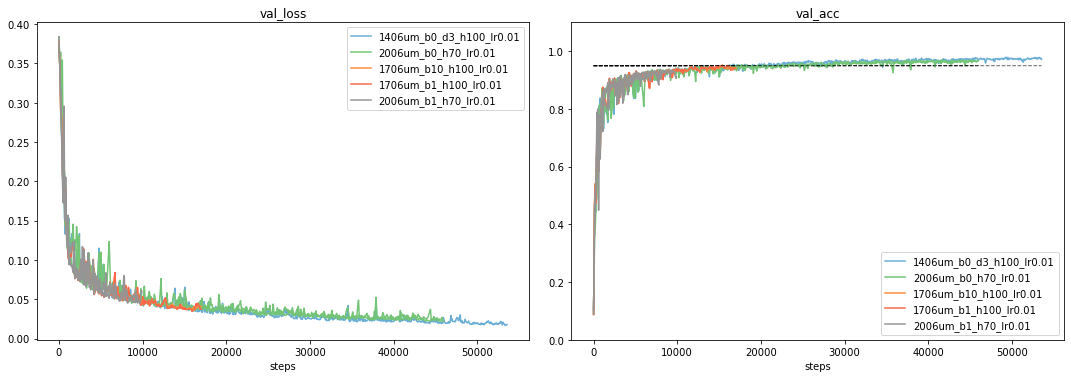

um_b1_h100_lr0.01_rep0
integral_values ({'um_b0_d3_h100_lr0.01_rep0': 0.0032237999664339986, 'um_b0_h70_lr0.01_rep0': 0.0047918714232791275, 'um_b0_h70_lr0.01_rep1': 0.0062634774576531054, 'um_b10_h100_lr0.01_rep0': -0.00015504580910018602, 'um_b1_h70_lr0.01_rep0': -0.00101020327301309, 'um_b1_h70_lr0.01_rep1': -0.0011085404509425187}, 'um_b1_h100_lr0.01_rep0', 41601)


In [479]:
integral_values_dict = dict()
patts_to_search2 = ['mnist_[a-z_0-9]*_lr0.01']
#patts_to_search2 = ['synth_split_b0_d5','synth_split_b1_d5','synth_split_b10+_d5','synth_split_b[0-9]*_d5']
#patts_to_search2 = ['synth_split_*_d5','synth_split_*_d6','synth_split_*_d7',]

# Mnist lr is 0.01
for patt in patts_to_search2: 
    val_accs_dict = plot_runs_w_regex(patt, 0.1, DL_LOG_PATH, verbose=True, delete_dir=False)
    integral_values = compute_integral_values(val_accs_dict)
    print('integral_values', integral_values)
    integral_values_dict[patt] = integral_values

# Log folds merger

In [503]:
import shutil
import itertools
from collections import Counter
from more_itertools import locate

def get_len_vals(dest_path):
    event_acc_old = EventAccumulator(dest_path)
    event_acc_old.Reload()
    try:
        _, step_nums, vals = zip(*event_acc.Scalars('val_acc'))
        return len(vals)
    except:
        return 0
    
def rename_w_rep(log_path):
    all_ckpt_dirs=os.listdir(log_path)
    all_ckpt_dirs = [el for el in all_ckpt_dirs if "DS_Store" not in el]
    for log_dir in all_ckpt_dirs:
        if not 'rep' in log_dir:
            fold_x = os.listdir(join(log_path,log_dir,'metrics'))
            fold_x = [el for el in fold_x if 'fold' in el]
            fold_nb = int(re.match('fold_([0-9]+)', fold_x).group(1))
            os.rename(join(log_path,log_dir), join(log_path,f'{log_dir}_rep{fold_nb}'))
            
def get_folds_to_merge(log_path, all_ckpt_dirs):
    
    patt = "(?:merged_)*([0-9]+)_[0-9]+_[0-9]+_[a-z]+_((?:um|rand|split)_b[0-9]+_d[0-9]+_*(s[0-9]*)*_+h[0-9]+_lr[0-9]+)"
    matched = [re.match(patt, el) for el in all_ckpt_dirs]
    hashes = [el.group(2) for el in matched] # create hashes
    counts = Counter(hashes)
    dup_hashes = [i for i in counts.keys() if counts[i] > 1] # keep only ckpts w duplicates
    dup_hashes = np.array(dup_hashes)
    print(dup_hashes)
    folds_to_merge = [all_ckpt_dirs[list(locate(hashes, lambda x: x == hash1))] for hash1 in dup_hashes] # get the actual paths
    print(folds_to_merge)
    folds_to_merge = [[join(log_path, fold, 'metrics') for fold in folds] for folds in folds_to_merge]
    return folds_to_merge
    
def merge_folds(log_path=LOG_PATH):
    rename_w_rep(log_path)
    all_ckpt_dirs = os.listdir(log_path)
    all_ckpt_dirs = np.array([el for el in all_ckpt_dirs if "DS_Store" not in el])
    
    #all_ckpt_dirs = [el for el in all_ckpt_dirs if re.search(re_patt_to_search, el)]
    folds_to_merge = get_folds_to_merge(log_path, all_ckpt_dirs)
    
    for folds in folds_to_merge: 
        for i, fold in enumerate(folds): 
            assert(os.path.isdir(fold))
            folds_x = os.listdir(fold)
            if len(folds_x) < 1:
                shutil.rmtree(fold)
                del folds[i]
            ds_store=join(fold, '.DS_Store')
            if os.path.isdir(ds_store): os.remove(ds_store)
    
    for folds in folds_to_merge:
        # find smallest fold nb
        prev_fold_nb = 100
        for i, fold in enumerate(folds):
            print(fold)
            min_fold_nb = int(re.match('[a-z0-9./_]*rep([0-9]+)', fold).group(1))
            folds_x = os.listdir(fold)
            folds_x = [el for el in folds_x if "DS_Store" not in el]
            merged_folds_nb = [int(re.match('fold_([0-9]+)', fold_x).group(1)) for fold_x in folds_x]
            if min_fold_nb < prev_fold_nb or ('merged' in fold):
                prev_fold_nb = min_fold_nb
                prev_fold_idx = i
                dest_path = fold
                merged_folds_nb = merged_folds_nb
                if ('merged' in fold): break
        
        if not 'merged' in dest_path:
            dest_path_idx = [i for i, letter in enumerate(dest_path) if letter == '/']
            dest_path_pre = dest_path[:dest_path_idx[2]]
            dest_path_ckpt = dest_path[dest_path_idx[2]+1:dest_path_idx[3]]
            dest_fold_path = dest_path[:dest_path_idx[-1]]
            new_dest_ckpt = f'merged_{dest_path_ckpt}'
            new_dest_fold_path = join(dest_path_pre, new_dest_ckpt)
            os.rename(dest_fold_path, new_dest_fold_path)
            del folds[prev_fold_idx]
            dest_path = join(new_dest_fold_path, 'metrics')
        
        for fold in folds:
            list_folds = os.listdir(fold)
            list_folds = [el for el in list_folds if "DS_Store" not in el]
            foldnb2 = int(re.match('fold_([0-9]+)', list_folds[0]).group(1))
            source_path = join(fold, list_folds[0])
            #print('dest_fold_nb', dest_path, merged_folds_nb, 'foldnb2', source_path, foldnb2)
            merged_folds_nb.append(foldnb2)
            do_move=True

            # Check if file already exists
            hyp_dest_path = join(dest_path, f'fold_{foldnb2}')
            #print(hyp_dest_path, source_path)
            if os.path.isdir(hyp_dest_path):
                print(hyp_dest_path,'exists in the destination path!')
                #rename incoming folder to part2
                new_source_path = join(source_path[:source_path.rfind('/')], f'fold_{foldnb2}_part2')
                os.rename(source_path, new_source_path)
                source_path = new_source_path
                
            if do_move:
                shutil.move(source_path, dest_path)

            folder = source_path[:source_path[:source_path.rfind('/')].rfind('/')]
            #print("TO remove", folder)
            shutil.rmtree(folder)
                

#27147228_2504_1617_synth_um_b0_d8_h300_lr5
!cd $DL_LOG_PATH
!find . -name '.DS_Store' -type f -delete
!echo DONE
merge_folds(TO_MERGE_LOG_PATH)


DONE
['split_b100_d6_s400_h120_lr1' 'split_b200_d6_s400_h120_lr1'
 'split_b0_d6_s400_h120_lr1' 'split_b10_d6_s400_h120_lr1'
 'split_b1_d6_s400_h120_lr1']
[array(['2623188_2106_0242_synth_split_b100_d6_s400_h120_lr1.0_rep2',
       '2623193_2106_0242_synth_split_b100_d6_s400_h120_lr1.0_rep7',
       '2623194_2106_0242_synth_split_b100_d6_s400_h120_lr1.0_rep8',
       '2623187_2106_0242_synth_split_b100_d6_s400_h120_lr1.0_rep1',
       '2623189_2106_0242_synth_split_b100_d6_s400_h120_lr1.0_rep3',
       '2623190_2106_0242_synth_split_b100_d6_s400_h120_lr1.0_rep4',
       '2623192_2106_0242_synth_split_b100_d6_s400_h120_lr1.0_rep6',
       '2623195_2106_0242_synth_split_b100_d6_s400_h120_lr1.0_rep9',
       '2623186_2106_0242_synth_split_b100_d6_s400_h120_lr1.0_rep0'],
      dtype='<U58'), array(['2623199_2106_0242_synth_split_b200_d6_s400_h120_lr1.0_rep3',
       '2623205_2106_0246_synth_split_b200_d6_s400_h120_lr1.0_rep9',
       '2623202_2106_0242_synth_split_b200_d6_s400_h120_lr1.0_re

In [8]:
def clean_folds(log_path=LOG_PATH):    
    all_ckpt_dirs = os.listdir(log_path)
    all_ckpt_dirs = [el for el in all_ckpt_dirs if "DS_Store" not in el]
    all_ckpt_dirs = [join(log_path, ckpt_path, 'metrics') for ckpt_path in all_ckpt_dirs]
    
    for ckpt in all_ckpt_dirs:
        folds = os.listdir(ckpt)
        for el in folds:
            if 'fold' not in el:
                el = join(ckpt, el)
                if os.path.isdir(el):
                    shutil.rmtree(el)
                else:
                    os.remove(el)
                
#clean_folds(log_path=DL_LOG_PATH)    